# MAP 512 : Tatouage numérique par code Tardos

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats

m = 2500 # Taille du tatouage : Fixée par la capacité d'accueil du support (doit être grand pour que les pi suivent bien la distribution)
n = 100000 # Nombre d'utilisateurs : Evolue au fur et à mesure que des utilisateurs se rajoutent
t = 1/300
c = 5 # Taille de la collusion maximale considérée

## Code de Tardos
Cette section propose plusieurs fonctions pour mettre en application la méthode proposée par Tardos.
- *matrice_identifiants* calcule une matrice de $n$ identifiants de taille $m$ par la méthode de Tardos. Les paramètres $p_i$ de Bernouilli de chaque bit de l'identifiant sont tirés selon la loi de densité $f(p) = \frac{Cte}{\sqrt{p(1-p)}}\mathbb{1}_{[t,1-t]}(p)$. On doit donc avoir $t<\frac{1}{2}$.
- *score_tardos* calcule le score de Tardos de l'identifiant $x$ par rapport à $y$ sachant la distribution des $p_i$.

### Calcul de la fonction de répartition de la loi de densité $f$
Le chagement de variable $q=\sqrt{p}$ donne :
$$\int_t^x{f\left(p\right)dp} = \int_t^x{\frac{Cte\cdot dp}{\sqrt{p(1-p)}}} = \int_\sqrt{t}^\sqrt{x}{\frac{Cte\cdot dq}{2\sqrt{(1-q^2)}}} = 2\cdot Cte\left[Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)\right]$$
Donc $Cte = \frac{1}{2\left[Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right]}$
et la fonction de répartition de cette loi vaut $F(x)=\frac{Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)}{Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)}$ sur $[t,1-t]$.  
Puis $F^{-1}(u)=sin^2\left[Arcsin\left(\sqrt{t}\right)+u\cdot\left(Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right)\right]$.

In [30]:
def matrice_identifiants(n,m,t):
    # On doit avoir t < 0.5
    u = npr.rand(m)
    p = np.sin(np.arcsin(np.sqrt(t)) + u*(np.arcsin(np.sqrt(1-t))-np.arcsin(np.sqrt(t))))
    p = p*p
    X = np.array(npr.binomial(1,p,(n,m)))
    return p,X

def generation_innocents(n,p):
    m = len(p)
    X = np.array(npr.binomial(1,p,(n,m)))
    return X

def score_tardos(x,y,p):
    return np.sum((1-2*(x*(1-y)+y*(1-x)))*((np.sqrt((1-p)/p))**(2*x-1)))

def score_tardos_matrix(X,y,p):
    return np.apply_along_axis(lambda x: score_tardos(x,y,p), axis=1, arr=X)

In [3]:
p,X = matrice_identifiants(n, m, t)
score_tardos(npr.rand(m), X[0], p)

-991.3977193490824

## Monte Carlo naïf pour trouver la p-valeur
Soit $y$ un identifiant trouvé dans une copie pirate et $x$ l'identifiant d'un utilisateur.  
On suppose les $p_i$ connus.  
Quelle est la probabilité $p_x$ qu'un innocent ai un score supérieur à celui de x ?  
Pour répondre à cette question nous utiliserons un estimateur Monte Carlo naïf :
$$\hat{p_x}=\frac{1}{N}\overset{N}{\underset{k = 1}\sum}{\mathbb{1}_{S\left(X_k\right)\geq S(x)}}\ \ \text{avec}\ \ X_k \overset{iid}{\sim}\left[\mathcal{Bernoulli}(p_i)\right]_{1\leq i\leq m}$$

In [4]:
def MC_naif(N,p,x,y):
    score = np.array([score_tardos(npr.binomial(1,p),y,p) for i in range(N)])
    return np.average(score >= score_tardos(x,y,p))

In [5]:
MC_naif(10000, p, X[0], npr.rand(m))

0.3866

## Stratégie de la collusion
Nous allons proposer et comparer 3 stratégies pour la collusion :
- *vote_majoritaire* : suit le principe du vote majoritaire
- *entrelacement* : un membre de la collusion est tiré uniformément pour chaque bit
- *pile_ou_face* : à chaque bit repérable par la collusion est attribué la valeur 1 avec probabilité $\frac{1}{2}$
- *vote_minoritaire* : suit le principe du vote minoritaire, tout en suivant la *marking assumption*

Nous rappelons que ces 3 stratégies respectent la *marking assumption* qui stipule : $$\forall i\in[|1,m|]  \ \ X_{1i}=X_{2i}=\cdots=X_{ci}\Rightarrow\rho_{C}(X)_{i} = X_{1i}$$
Avec $C = [|1,c|]$ la collusion et $\rho_C$ leur strategie.

In [18]:
def vote_majoritaire(C):
    return np.round(np.average(C,axis=0))

def entrelacement(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    c = len(C)
    u = npr.randint(low=0, high=c, size=m)
    return C[u,:].diagonal()

def pile_ou_face(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = npr.randint(low=0, high=2, size=m)
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u
    
def vote_minoritaire(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = 1 - np.round(np.average(C,axis=0))
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u

In [7]:
C = X[0:3]
vote_majoritaire(C)
entrelacement(C)
pile_ou_face(C)

array([0, 1, 0, ..., 0, 1, 0])

## Distribution empirique des scores des innocents et des colludés
Le but de cette partie est de fournir une repésentation empirique de la distribution des scores des innocents face à une réponse pirate trouvée, et de la comparer à celles des membres de la collusion.  
Cette étude se fait pour les trois stratégies envisagées ci-dessus.

In [20]:
def choix_collusion(X,c):
    C_indices = npr.choice(range(len(X)), size=c, replace=False)
    return C_indices
    
def calcul_marque_pirate(C,strategie):
    return strategie(C)

def prendre_C(indices_collusion,X):
    return X[indices_collusion,:]

def calcul_scores(X,p,c,strategie):
    n = len(X)
    # Choix de la collusion
    C_indices = choix_collusion(X,c)
    C = prendre_C(C_indices,X)
    # Etablissement de la marque pirate
    y = calcul_marque_pirate(C,strategie)
    # Calculs des scores des innocents
    Innocents_indices = list(set(range(n)) - set(C_indices))
    X_innocents = X[Innocents_indices,:]
    Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    # Calcul des scores des colludés
    Scores_colludes = score_tardos_matrix(C,y,p)
    return Scores_innocents,Scores_colludes

def affichage(Scores_innocents,Scores_colludes,nom_strategie):
    plt.hist(Scores_colludes, bins=100, density=True, color='r', label='Colludés')
    # Estimation de la densité par noyau gaussien pour les innocents
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    x_plot = np.linspace(-200,400,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,0,np.sqrt(m)),linestyle=':',label="Gaussienne centrée de variance m")
    plt.ylim(0,0.01)
    plt.legend()
    plt.savefig("distribution_innocents_vs_"+nom_strategie+".png",dpi=1000)
    plt.show()
    
def calcul_scores_colludes(X,p,c,strategie):
    n = len(X)
    Scores_colludes = []
    N = 10000
    for k in range(N):
        # Choix de la collusion
        C_indices = choix_collusion(X,c)
        C = prendre_C(C_indices,X)
        # Etablissement de la marque pirate
        y = calcul_marque_pirate(C,strategie)
        # Calcul des scores des colludés
        Scores_colludes.append(score_tardos_matrix(C,y,p))
        if k==0:
            # Calculs des scores des innocents
            Innocents_indices = list(set(range(n)) - set(C_indices))
            X_innocents = X[Innocents_indices,:]
            Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    return Scores_innocents,np.array(Scores_colludes).flatten()

def affichage_colludes(Scores_innocents,Scores_colludes,nom_strategie):
    # Estimation des densités par noyau gaussien
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    densite_coupables = scipy.stats.gaussian_kde(Scores_colludes)
    mu = np.average(Scores_colludes)
    x_plot = np.linspace(-200,600,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.plot(x_plot, densite_coupables.evaluate(x_plot), color='r', label='Colludés')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,mu,np.sqrt(m)),linestyle=':',label="Gaussienne de variance m")
    plt.ylim(0,0.01)
    plt.legend()
    plt.savefig("distribution_innocents_colludes_"+nom_strategie+".png",dpi=1000)
    plt.show()

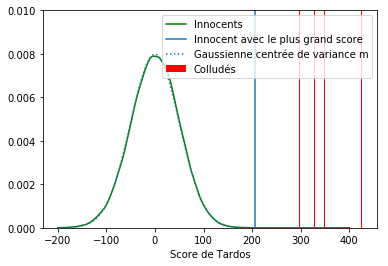

In [9]:
si,sc = calcul_scores(X,p,c,vote_majoritaire)
affichage(si,sc,"vote_majoritaire")

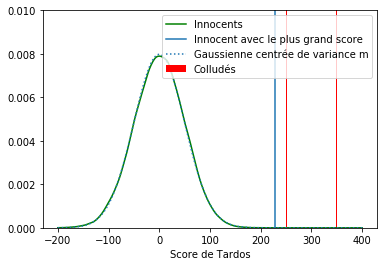

In [10]:
si,sc = calcul_scores(X,p,c,entrelacement)
affichage(si,sc,"entrelacement")

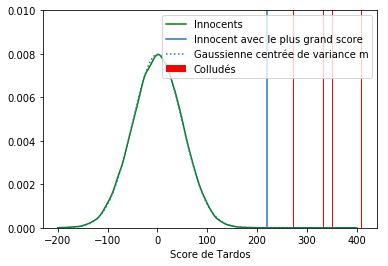

In [11]:
si,sc = calcul_scores(X,p,c,pile_ou_face)
affichage(si,sc,"pile_ou_face")

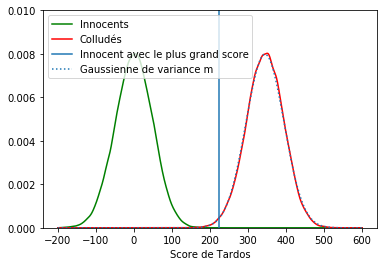

In [12]:
si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
affichage_colludes(si,sc,"vote_majoritaire")

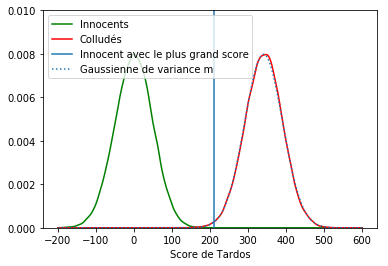

In [13]:
si,sc = calcul_scores_colludes(X,p,c,entrelacement)
affichage_colludes(si,sc,"entrelacement")

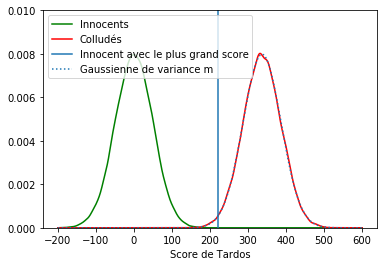

In [14]:
si,sc = calcul_scores_colludes(X,p,c,pile_ou_face)
affichage_colludes(si,sc,"pile_ou_face")

## Adaptative Monte-Carlo

In [24]:
def tri_vect(Z):
    # Ordonne le vecteur par score, qui est stocké en première coordonnée
    return np.sort(Z,axis=0) 

def clonage(X,Z):
    # Va clonner les tatouages des utilisateurs tirés avec un score inférieur à la médiane 
    #    sur ceux supérieurs à cette dernière
    Z = tri_vect(Z)
    n = len(X)
    pas = int((n+1)/2)
    mediane = Z[int((n)/2),0]
    for k in range(int((n)/2)):
        j_1 = int(Z[k,1])
        j_2 = int(Z[k+pas,1])
        # Remplace l'utilisateur avec le i-ième score plus bas par le median + i
        X[j_1,:] = X[j_2,:]
        Z[j_1,0]=Z[j_2,0]
    return X,Z,mediane

In [45]:
def etape_MH(X,Z,p,y,J,T):
    X,Z,seuil = clonage(X,Z)
    n = len(X)
    # Tirage les J bits du tatouage qui vont changer
    bits_a_changer = npr.choice(m,size=J,replace=False) 
    # On fait varier seulement la moitié des joeurs avec les scores les plus faibles
    for t in range(T):
        for j in range(int(n/2)):
            # Copie du tatouage du j-ième utilisateur
            x_j = X[int(Z[j,1]),:]
            # Tirage des J bits à changer
            for k in range(J): 
                x_j[bits_a_changer[k]] = np.random.binomial(1,p[bits_a_changer[k]])# aleatoire_k_bit 
            score_j = score_tardos(x_j,y,p) 
            # Critère de Metropolis-Hasting pour le rejet
            if(score_j >= seuil):
                X[int(Z[j,1]),:] = x_j
                Z[j,0] = score_j
    Z = tri_vect(Z)
    nouveau_seuil = Z[int((n)/2),0]
    return X,Z,nouveau_seuil           
                
def MC_Adaptative(p,y,score_lim,J,T,N):
    # p est le vecteur des p_i
    # y est la marque pirate
    # score_lim est le score pour lequel on veut calculer la p-value
    # HYPERPARAMETRES:
    # J est la quantite de bits à changer
    # T est la quantite de saut dans l'algorithme de Metropolis-Hasting
    # N le nombre de points pour chaque étape
    X = generation_innocents(N,p)
    S = score_tardos_matrix(X,y,p)
    # Z est le vector des scores avec en deuxième coordonnée l'identifiant (indice de ligne dans X) de l'utilisateur
    Z = np.zeros((len(S),2))
    # Z[i,1] est le i-ème utilisateur dans la liste qui a originé S
    Z[:,0] = S
    Z[:,1] = range(len(S))
    Z = tri_vect(Z)
    seuil = Z[len(X)//2,0]
    print(seuil)
    i = 0
    while (seuil<score_lim):
        X,Z,seuil = etape_MH(X,Z,p,y,J,T)
        print(seuil)
        i += 1
    # On a donc depasser le seuil
    # On va maintenant corrigé la dernière probabilité
    p_final = np.average(Z[:,0] <= score_lim)
    print(p_final)
    return (1/2)**(i-1)*p_final

In [42]:
J = 10
T = 5
N = 10000
score_lim = 10
C_indices = choix_collusion(X,c)
C = prendre_C(C_indices,X)
y = calcul_marque_pirate(C,pile_ou_face)

In [46]:
MC_Adaptative(p,y,score_lim,J,T,N)

0.5484405737368547
33.20714249723283
0.1664


0.1664